In [139]:
import pyedflib # ref: https://pyedflib.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import fnmatch
sns.set(font_scale=1.2)


In [140]:
read_folder = './clips/'
# subjects: 4001(E0, EC), 4032(E0, EP), 4191(E0, EP)
# 4742
# id = 'SC4032'
pattern1 = '*-PSG.edf'
pattern2 = '*-Hypnogram.edf'

psg_list = sorted([f for f in os.listdir(read_folder) if fnmatch.fnmatch(f, pattern1)])
hypnogram_list = sorted([f for f in os.listdir(read_folder) if fnmatch.fnmatch(f, pattern2)])

# psg_id = [s for s in psg_list if id in s][0]
# hypnogram_id = [s for s in hypnogram_list if id in s][0]
num = min(len(psg_list), 1) - 1
psg_id = psg_list[num]
hypnogram_id = hypnogram_list[num]

print(psg_id, hypnogram_id)
channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal']
channel = channels[1]
signal_path = os.path.join(read_folder, psg_id)
label_path = os.path.join(read_folder, hypnogram_id)

SC400100E0-PSG.edf SC400100EC-Hypnogram.edf


#### Old pySleepEDF snippets


In [141]:
# read EDF files
if 'edf_label' and 'edf_label' in globals():
    del edf_signal, edf_label

edf_signal = pyedflib.EdfReader(signal_path)
edf_label = pyedflib.EdfReader(label_path)

# read data
annotations = edf_label.readAnnotations()
start = edf_signal.getStartdatetime()
signals, frequencies = edf_signal.getSignalLabels(), edf_signal.getSampleFrequencies()
data = []
for ch_idx, sig_name, freq in zip( range(len(signals)), signals, frequencies,):
    sig = edf_signal.readSignal(chn=ch_idx)
    idx = pd.date_range(  start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s") )
    data += [pd.Series(sig, index=idx, name=sig_name)]


# COntinue

In [142]:
# create DataFrames
annotations_df = pd.DataFrame(annotations)
annotations_df = annotations_df.T
annotations_df.rename(columns={0: "Onset", 1: "Duration", 2:"Annotations"}, inplace=True)
signal_df =pd.concat(data[:3], axis=1)

In [143]:
signal_df['N1'] = 0

def check_sleep_stage(row):
    start_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1]))
    end_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1])) + timedelta(seconds = int(annotations_df['Duration'].iloc[1]))
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)

signal_df['N1'] = signal_df.apply(check_sleep_stage, axis=1)

In [144]:
print(annotations_df['Onset'].iloc[1])
annotations_df['Duration'].iloc[1]

600.0


120.0

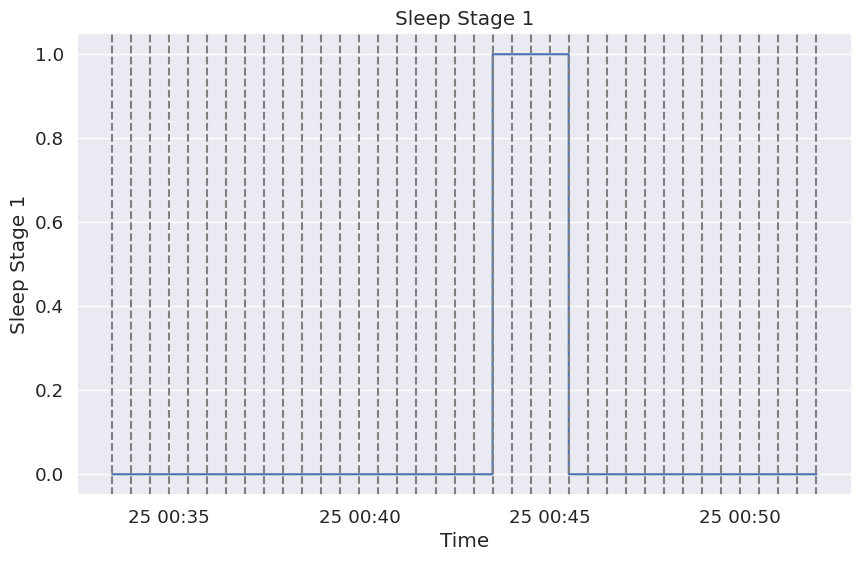

In [145]:
plt.figure(figsize=(10, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['N1'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
# 設定圖表標題和標籤
plt.title('Sleep Stage 1')
plt.xlabel('Time')
plt.ylabel('Sleep Stage 1')

# 顯示圖表
plt.show()
# plt.savefig('/fig/' + )

## Testing avg...

AVG: 24.786873357753358 11.887589743589743 36.6744631013431


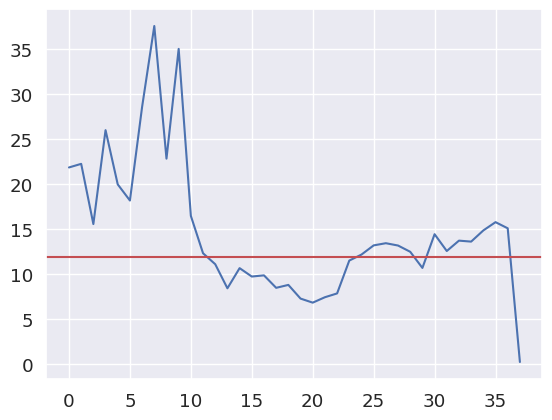

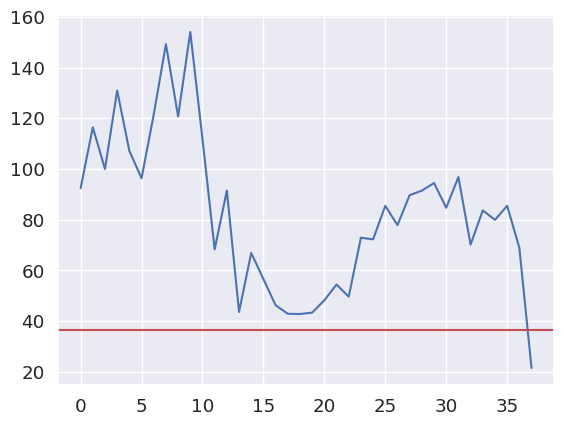

In [146]:
# N = signal_df.shape[0]
# val = abs(signal_df.iloc[:,0].values)
# X = []
# ay = []
# my = []
# # try avg first 10 windows
# max_win = 0
# avg_win = 0
# for i in range(0, N, 3000):
#     avg = val[i:i+3000].mean()
#     max = val[i:i+3000].max()
#     if i < 30000:
#         avg_win += avg
#         max_win += max
#     # print(i, avg)
#     X.append(i/3000)
#     ay.append(avg)
#     my.append(max)
# calc_avg_win = avg_win/10
# calc_max_win = max_win/100
# summ = calc_avg_win + calc_max_win
# print("AVG:", calc_avg_win, calc_max_win, summ)
# plt.plot(X,ay)
# plt.axhline(y=calc_max_win, color='r', linestyle='-')
# plt.show()
# plt.plot(X,my)
# plt.axhline(y=summ, color='r', linestyle='-')
# plt.show()


## con

In [1269]:
def get_n1_index(signal_df, threshold=25):
    index = []
    index_series = []
    # 0, 3000, 6000
    N = signal_df.shape[0]
    # # FIXED VARIABLE
    # threshold = 25

    for i in range(0, N, 1500):
        mxcount = 0
        count = 0
        try:
            for j in range(3000):
                if(abs(signal_df.iloc[i+j,0]) < threshold and abs(signal_df.iloc[i+j-1,0]) < threshold):
                    count += 1
                else:
                    if(count > mxcount):
                        mxcount = count
                    count = 0
            mxcount = max(mxcount, count)
        except:
            pass
        # print(i,mxcount)
        index_series.append(mxcount)
        if(mxcount > 1500):
            index.append(i)
    # len(index)
    return index

In [1270]:
from scipy import signal

sf=100.0
start_time = 1025
interval = 30
start_idx = int(start_time * sf)
end_idx = min(int((start_time + interval) * sf), len(signal_df))
data_range = signal_df.iloc[start_idx:end_idx]

In [1271]:
write_folder = './plots/'
os.makedirs(write_folder, exist_ok=True)
pattern1 = '*-PSG.edf'
pattern2 = '*-Hypnogram.edf'

In [1272]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import pandas as pd
def lol(signal_df, save_fig=False):
    num_columns = len(signal_df.columns)

    fig, axes = plt.subplots(num_columns, 1, figsize=(20, 12), sharex=True)

    # 迴圈遍歷每個欄位
    for i, column in enumerate(signal_df.columns):
        # 取得目前的軸
        ax = axes[i]

        # 繪製折線圖
        ax.plot(signal_df.index, signal_df[column])
        
        # 繪製虛線
        start_time = signal_df.index[0]
        end_time = signal_df.index[-1]
        interval = pd.Timedelta(seconds=30)
        current_time = start_time + interval
        while current_time < end_time:
            ax.axvline(x=current_time, linestyle='--', color='gray')
            current_time += interval

        # 設定軸的標籤
        ax.set_ylabel(column)
        loc = mdates.MinuteLocator(interval=1)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 設定圖表標題和共用 x 軸標籤
    fig.suptitle('Signal Visualization')
    axes[-1].set_xlabel('Time')
    # 調整子圖之間的間距
    plt.tight_layout()
    plt.ylim(0,10)
    # 顯示圖表
    if save_fig:
        plt.savefig(write_folder + psg_id.split('.')[0],bbox_inches='tight')
    else:
        plt.show()



## USELESS

In [1273]:
# signal_df.iloc[:,:]

In [1274]:
# signal_df.iloc[60000,:]

In [1275]:
# signal_df[signal_df['N1'] == 1]

In [1276]:



# # Define window length (4 seconds)
# win = 3 * sf
# freqs, psd = signal.welch(signal_df.iloc[60000:63000,0], sf, nperseg=win)

# # Plot the power spectrum
# # sns.set(font_scale=1.2, style='white')
# # plt.figure(figsize=(8, 4))
# # plt.plot(freqs, psd, color='k', lw=2)
# # plt.xlabel('Frequency (Hz)')
# # plt.ylabel('Power spectral density (V^2 / Hz)')
# # plt.ylim([0, psd.max() * 1.1])
# # plt.title("Welch's periodogram")
# # plt.xlim([0, 10])
# # sns.despine()

In [1277]:
# # Define delta lower and upper limits
# low, high = 0.5, 4

# # Find intersecting values in frequency vector
# idx_delta = np.logical_and(freqs >= low, freqs <= high)
# # print(idx_delta)
# # Plot the power spectral density and fill the delta area
# # plt.figure(figsize=(7, 4))
# # plt.plot(freqs, psd, lw=2, color='k')
# # plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
# # plt.xlabel('Frequency (Hz)')
# # plt.ylabel('Power spectral density (uV^2 / Hz)')
# # plt.xlim([0, 10])
# # plt.ylim([0, psd.max() * 1.1])
# # plt.title("Welch's periodogram")
# # # sns.despine()

## Alpha power

In [1278]:
# len(signal_df.iloc[:])

In [1279]:
# 0.01 s = 1 block
# all 36 block

In [1280]:
index = []
# index_series = []
# 0, 3000, 6000
N = signal_df.shape[0]
# FIXED VARIABLE
threshold = 30

for i in range(0, N, 1500):
    mxcount = 0
    count = 0
    try:
        for j in range(3000):
            if(abs(signal_df.iloc[i+j,0]) < threshold and abs(signal_df.iloc[i+j-1,0]) < threshold):
                count += 1
            else:
                if(count > mxcount):
                    mxcount = count
                count = 0
        mxcount = max(mxcount, count)
    except:
        pass
    # print(i,mxcount)
    # index_series.append(mxcount)
    if(mxcount > 1500):
        index.append(i)
len(index)


5

In [1281]:
def eog_n1_predict(signal_df, window = 5, ratio = 0.5):
    
    # window = moving average window
    # ratio = if max value * ratio < all seen values in the interval, then N1
    index_eog = []
    N = signal_df.shape[0]
    # FIXED VARIABLE
    sum_max = 0
    seen = 0 # how many intervals passed


    for i in range(0, N, 3000):
        max_len = min(i+3000, N)
        cur_max = signal_df.iloc[i:max_len].max()
        if seen > window:
            avg = (sum_max / seen)
            if avg * ratio > cur_max:
                print("FOUND")
                return [i]
            else:
                print(f"cur_max: {cur_max}, avg: {avg}")
        sum_max += cur_max
        seen += 1
    


In [1282]:
val = eog_n1_predict(signal_df['EOG horizontal'], window = 10, ratio = 0.47)
print(val)

FOUND
[33000]


In [1283]:
# # plot a horizontal line at y = 1500
# plt.figure(figsize=(20, 6))
# plt.plot(index_series)
# plt.axhline(y=1500, color='r', linestyle='-')
# plt.show()

In [1284]:
print(index)

[55500, 57000, 58500, 60000, 61500]


In [1285]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [1286]:
butt = butter_bandpass_filter(signal_df['EOG horizontal'], 8, 12, 100, order=6)

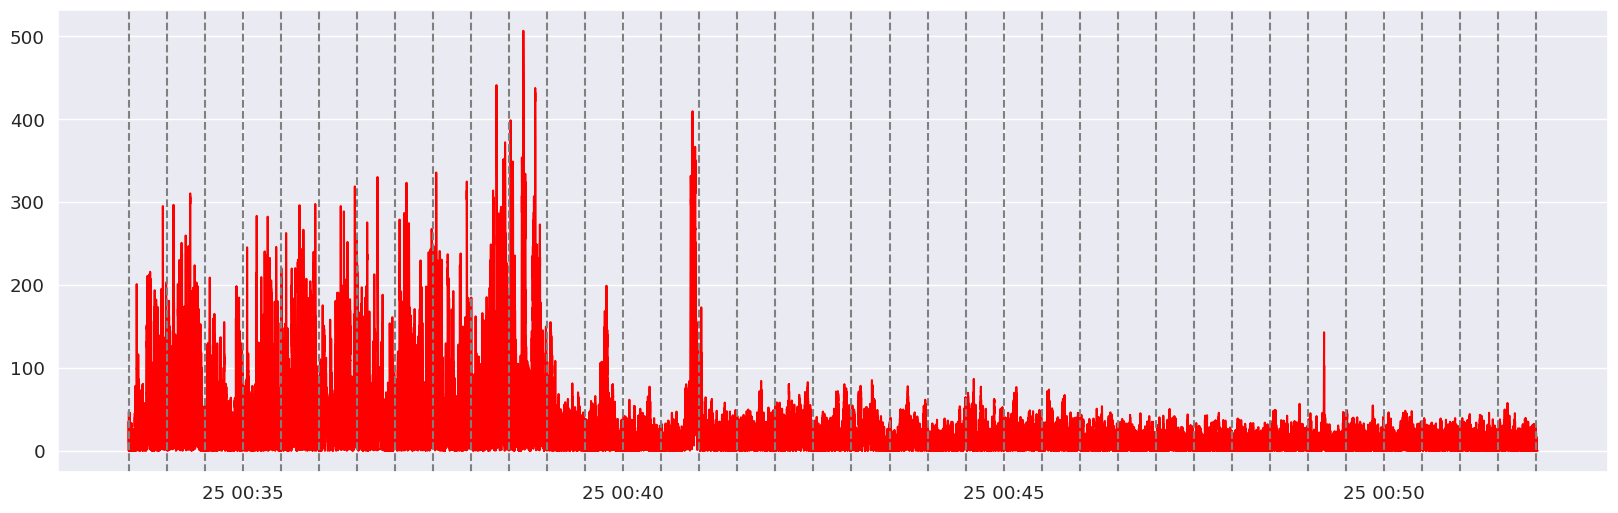

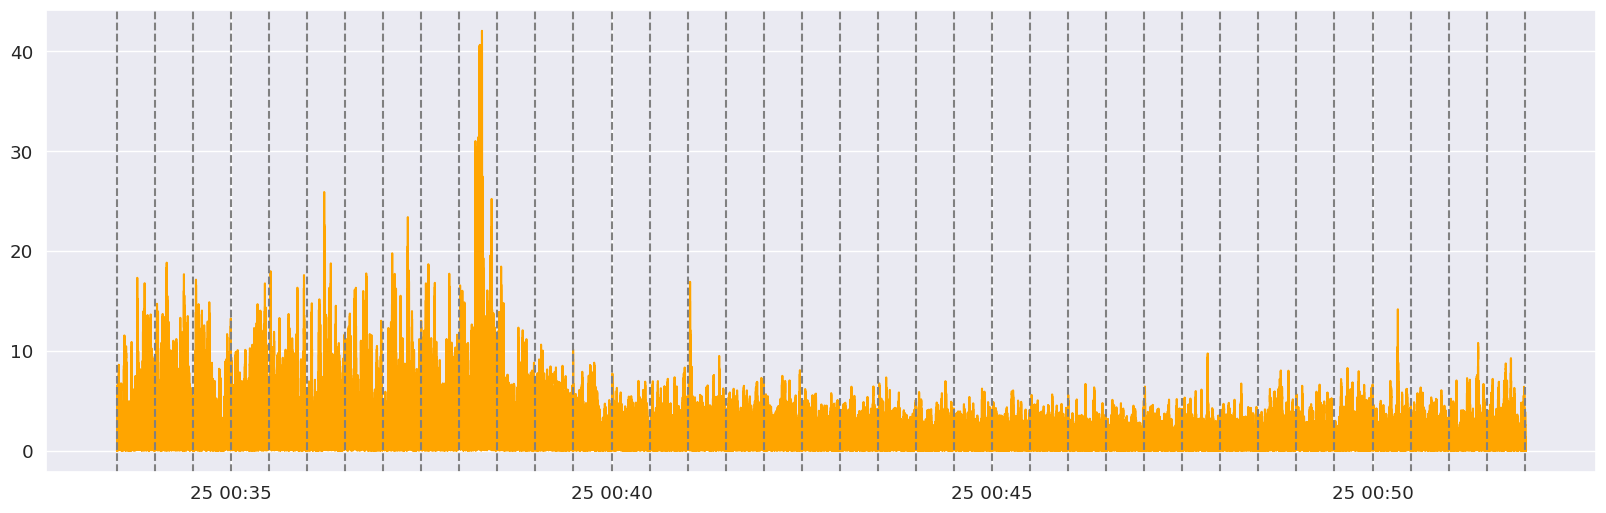

In [1287]:
# plt.plot(signal_df.index,signal_df['EOG horizontal'], color='red')
# plt.plot(signal_df.index,butt, color = 'orange')
# plt.show()
# plot signal_df and butt on different graph but have the same scaling
plt.figure(figsize=(20, 6))
plt.plot(signal_df.index,abs(signal_df['EOG horizontal']), color='red')
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
plt.show()
plt.figure(figsize=(20, 6))
plt.plot(signal_df.index,abs(butt), color = 'orange')
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
plt.show()

# pd_butt = pd.DataFrame(butt)

# sma = pd_butt.rolling(40).mean()
# plt.figure(figsize=(20, 6))
# plt.plot(abs(sma), color = 'blue')
# # time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
# # for time_tick in time_ticks:
# #     plt.axvline(time_tick, color='gray', linestyle='--')
# plt.ylim(0,2)
# plt.show()

# ema = pd_butt.ewm(span=3).mean()
# plt.figure(figsize=(20, 6))
# plt.plot(abs(ema), color = 'blue')
# plt.ylim(0,10)
# plt.show()


# weights = [0.1, 0.15, 0.2, 0.25, 0.3]
# wma = pd_butt.rolling(10).apply(lambda x: sum(weights*x) / sum(weights), raw=True)
# plt.figure(figsize=(20, 6))
# plt.plot(wma, color = 'blue')
# plt.show()


In [1288]:
# signal_df['N1_predict_EEG'] = 0

def check_sleep_stage_predict(row, start_index, duration):
    start_time = start + timedelta(seconds = start_index)
    end_time = start + timedelta(seconds = start_index) + timedelta(seconds = duration)
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)


if len(index) == 0:
    pass
elif len(index) == 1:
    signal_df['N1_predict_EEG'] = signal_df.apply(check_sleep_stage_predict, args=(int(index[0]/100), int(max(index)/100) + 1.5), axis=1) 
elif len(index) == 2:
    signal_df['N1_predict_EEG'] = signal_df.apply(check_sleep_stage_predict, args=(int(index[0]/100), int(max(index)/100)), axis=1)
else:
    signal_df['N1_predict_EEG'] = signal_df.apply(check_sleep_stage_predict, args=(int(index[0]/100), int((max(index)-index[1])/100)), axis=1)    

if len(val) == 0:
    pass
elif len(val) == 1:
    signal_df['N1_predict_EOG'] = signal_df.apply(check_sleep_stage_predict, args=(int(val[0]/100), int(max(val)/100) + 1.5), axis=1) 

empty_EEG = signal_df['N1_predict_EEG'].eq(0).all()
empty_EOG = signal_df['N1_predict_EOG'].eq(0).all()
if (not empty_EEG and not empty_EOG):
    signal_df['N1_predict'] = (signal_df['N1_predict_EEG'] & signal_df['N1_predict_EOG'])
    if signal_df['N1_predict'].eq(0).all():
        signal_df['N1_predict'] = signal_df['N1_predict_EOG']
if not empty_EEG:
    signal_df['N1_predict'] = signal_df['N1_predict_EEG']
elif not empty_EOG:
    signal_df['N1_predict'] = signal_df['N1_predict_EOG']

In [1289]:
# plt.figure(figsize=(10, 6))
# # 繪製signal_df['sleep_stage_1']的折線圖
# plt.plot(signal_df.index, signal_df['N1_predict'])

# # 繪製灰色虛線
# time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
# for time_tick in time_ticks:
#     plt.axvline(time_tick, color='gray', linestyle='--')
# # 設定圖表標題和標籤
# plt.title('Sleep Stage 1 Predict')
# plt.xlabel('Time')
# plt.ylabel('Sleep Stage 1')

# # 顯示圖表
# plt.show()
# # plt.savefig('/fig/' + )

In [1290]:
# index = []
# # 0, 3000, 6000
# N = signal_df['EOG horizontal']
# a = signal.butter(6, [8, 12], fs = 100, btype='band')
# w,h = signal.freqz(a[0],a[1],fs=100)
# print(a)

In [1291]:
# index = []
# # 0, 3000, 6000
# N = signal_df.shape[0]
# window = 30 * sf
# thres = 8

# for i in range(0, N, 3000):
#     count = 0
#     last = min(N, i+3000)
#     temp = signal_df.iloc[i: last, 0]
    
#     cond = abs(temp) < thres
#     print(temp[cond])
#     break
    
#     if(count > sf/2):
#         index.append(i)
# len(index)


In [1292]:
# index

In [1293]:
# c = abs(signal_df.iloc[:,0]) < 1
# d = signal_df.iloc[:,3] == True
# signal_df[c]

In [1294]:
# signal_df[d]

In [1295]:
# signal_df[c & d]

In [1296]:
# signal_df.shape

In [1297]:
# # Define window length (3 seconds)
# win = 3 * sf
# # freqs, psd = signal.welch(signal_df.iloc[60000:63000,0], sf, nperseg=win)
# freqs, psd = signal.welch(signal_df.iloc[:3000,0], sf, nperseg=win)

# # Plot the power spectrum
# sns.set(font_scale=1.2, style='white')
# plt.figure(figsize=(8, 4))
# plt.plot(freqs, psd, color='k', lw=2)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power spectral density (V^2 / Hz)')
# plt.ylim([0, psd.max() * 1.1])
# plt.title("Welch's periodogram")
# plt.xlim([0, 10])
# sns.despine()

In [1298]:
# # Define alpha lower and upper limits
# low, high = 8, 13

# # Find intersecting values in frequency vector
# idx_alpha = np.logical_and(freqs >= low, freqs <= high)
# # print(idx_alpha)
# # Plot the power spectral density and fill the delta area
# plt.figure(figsize=(7, 4))
# plt.plot(freqs, psd, lw=2, color='k')
# plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power spectral density (uV^2 / Hz)')
# plt.xlim([0, 10])
# plt.ylim([0, psd.max() * 1.1])
# plt.title("Welch's periodogram")
# sns.despine()

In [1299]:
# from scipy.integrate import simps

# # Frequency resolution
# freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# # Compute the absolute power by approximating the area under the curve
# alpha_power = simps(psd[idx_alpha], dx=freq_res)
# print('Absolute alpha power: %.3f uV^2' % alpha_power)

In [1300]:
# from scipy.integrate import simps
# # Relative delta power (expressed as a percentage of total power)
# total_power = simps(psd, dx=freq_res)
# alpha_rel_power = alpha_power / total_power
# print('Relative alpha power: %.3f' % alpha_rel_power)

### Try to slide to find the power relative

In [1301]:
# len(signal_df)

In [1302]:
# signal_df[signal_df.iloc[:,0] < 0]

In [1303]:
# signal_df.iloc[3000:6000,0]

In [1304]:
from scipy import signal

sf=100.0
sec = 30
sliding_interval = int(10 * sf)
interval = int(sf * sec)
plot = []
freq = {
    'alpha': (8, 12),
    'beta': (12, 30),
    'delta': (0.5, 4),
    'theta': (4, 8),
}

for start_time in range(0, len(signal_df), sliding_interval):
    start_idx = start_time
    end_idx = min(len(signal_df), start_idx + interval)
    data_range = signal_df.iloc[start_idx:end_idx]

    win = 4 * sf
    freqs, psd = signal.welch(data_range.iloc[:,0], sf, nperseg=win)

    dicts = {}
    for freq_name, (low, high) in zip(freq.keys(), freq.values()):

        idx = np.logical_and(freqs >= low, freqs <= high)

        # # ===============================
        from scipy.integrate import simps
        # Frequency resolution
        # print(freqs)
        freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

        # # Compute the absolute power by approximating the area under the curve
        power = simps(psd[idx], dx=freq_res)
        # print(f'Absolute {freq_name} power: {power} uV^2')

        # # Relative power (expressed as a percentage of total power)
        total_power = simps(psd, dx=freq_res)
        relative_power = power / total_power
        # print(f'Relative {freq_name} power: {relative_power}')

        dicts['Index'] = data_range.index[0]
        dicts[f'{freq_name}_pow'] = power
        dicts[f'{freq_name}_relative_pow'] = relative_power

        plot.append(dicts)

    df_plot = pd.DataFrame(plot, index = [x['Index'] for x in plot])
    df_plot.drop(columns=['Index'], inplace=True)

/home/jojo/mambaforge/envs/sleep-linear/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 400 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


In [1305]:
# df_plot

In [1306]:
# lol(pd.concat([signal_df, df_plot.iloc[:,:2], df_plot.iloc[:,-2:]], axis=0))

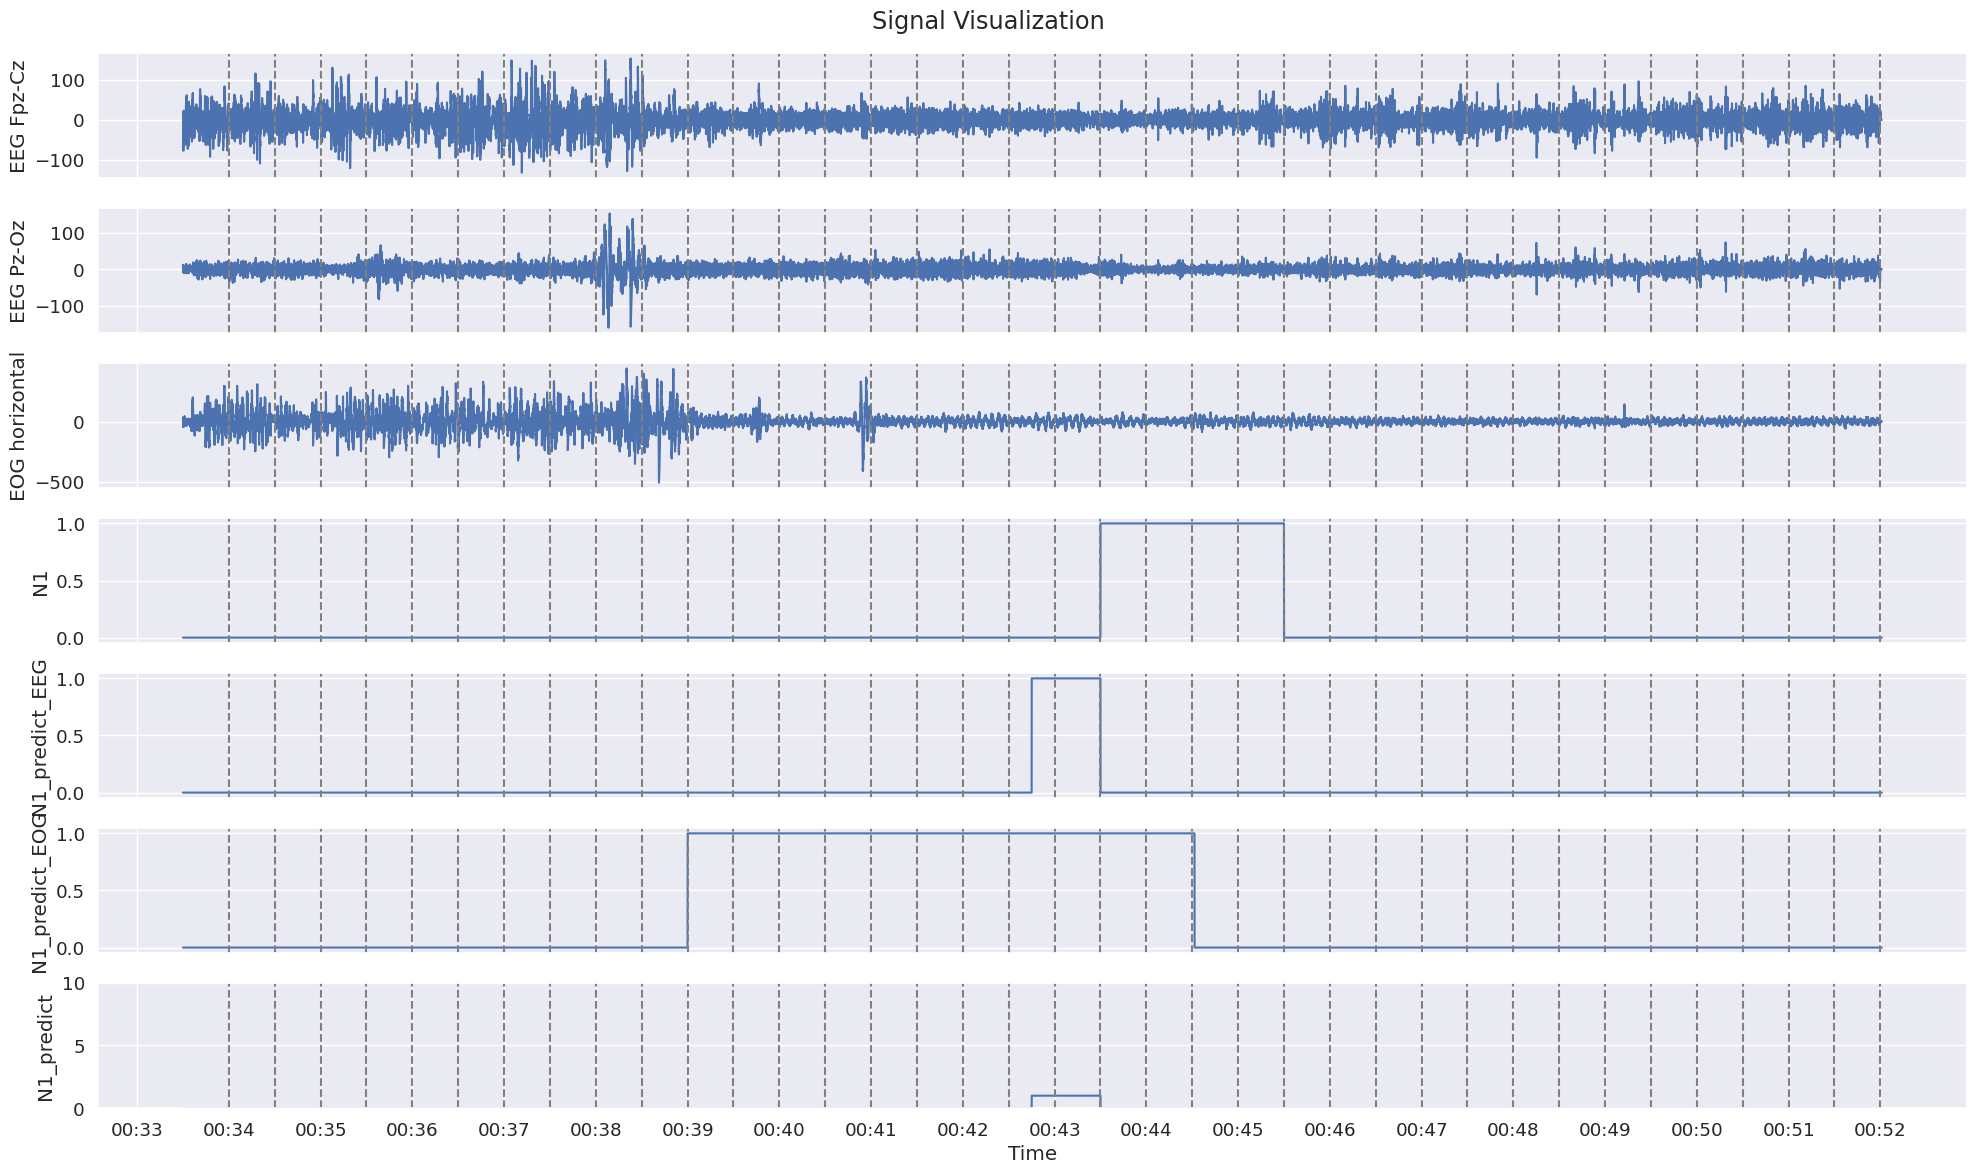

In [1307]:
lol(pd.concat([signal_df], axis=0))